In [1]:
### Loading the relevant package  ####
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timeDate);library(Metrics);
library(hydroGOF);library(imputeTS);library(readxl);library(forecastML);library(neuralnet);
library(randomForest);library(glmnet)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks 

In [2]:
## Data loading and cleaning  ##
## Reading the excel file, starting with 12 line and giving NA as None value
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [3]:
## Converting the data into daily time series
daily_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    dates = as.Date(paste0(day, "-", month, "-", year), "%d-%m-%Y"),
    PM2.5 = ifelse(PM25 <=10 ,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(dates, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM25 = mean(PM25, na.rm = TRUE)) %>%
  mutate(week = week(dates))

## Putting NA if there are null values 
daily_df$PM25[is.nan(daily_df$PM25)] <- NA
head(daily_df)

`summarise()` has grouped output by 'dates', 'day', 'month'. You can override using the `.groups` argument.



dates,day,month,year,PM25,week
<date>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01,1,1,2016,359.5730,1
2016-01-02,2,1,2016,327.9150,1
2016-01-03,3,1,2016,341.3188,1
2016-01-04,4,1,2016,480.0688,1
2016-01-05,5,1,2016,433.3537,1
2016-01-06,6,1,2016,371.7995,1


In [4]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till May 2019

seasonalIndex <- daily_df %>% filter(dates < as.Date("2020-12-31"))


############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

head(daily_s)


`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



month,day,2016,2017,2018,2019,2020
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,359.5730,199.8817,481.6250,380.2292,367.3750
1,2,327.9150,257.1204,359.6667,418.4688,361.6875
1,3,341.3188,271.6446,287.7083,412.8854,378.6765
1,4,480.0688,270.1217,351.6250,291.9479,216.5625
1,5,433.3537,246.8504,306.2500,241.6667,190.5938
1,6,371.7995,189.3525,324.7500,191.8542,166.8646


,month,day,2016,2017,2018,2019,2020,meanindex,summary_mean,dailyindex
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,359.5730,199.8817,481.6250,380.2292,367.3750,357.7368,138.1901,258.8729
2,1,2,327.9150,257.1204,359.6667,418.4688,361.6875,344.9717,138.1901,249.6356
3,1,3,341.3188,271.6446,287.7083,412.8854,378.6765,338.4467,138.1901,244.9138
4,1,4,480.0688,270.1217,351.6250,291.9479,216.5625,322.0652,138.1901,233.0595
5,1,5,433.3537,246.8504,306.2500,241.6667,190.5938,283.7429,138.1901,205.3279
6,1,6,371.7995,189.3525,324.7500,191.8542,166.8646,248.9242,138.1901,180.1317


In [5]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

head(weekly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



week,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,385.6715,239.1619,351.9375,322.8420,280.2933
2,349.6154,169.9775,265.8299,259.8899,175.8200
3,250.1298,165.8277,298.4800,283.6310,148.2443
4,324.5103,163.5439,186.7424,118.1771,190.7699
5,302.3383,178.0511,169.1964,189.1205,110.1656
6,219.2755,151.1387,192.8178,166.1840,158.7121


,week,2016,2017,2018,2019,2020,meanindex,summary_mean,weeklyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,385.6715,239.1619,351.9375,322.8420,280.2933,315.9812,141.8429,222.7684
2,2,349.6154,169.9775,265.8299,259.8899,175.8200,244.2265,141.8429,172.1810
3,3,250.1298,165.8277,298.4800,283.6310,148.2443,229.2626,141.8429,161.6313
4,4,324.5103,163.5439,186.7424,118.1771,190.7699,196.7487,141.8429,138.7089
5,5,302.3383,178.0511,169.1964,189.1205,110.1656,189.7744,141.8429,133.7919
6,6,219.2755,151.1387,192.8178,166.1840,158.7121,177.6256,141.8429,125.2270


In [6]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
head(monthly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



month,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,329.30722,182.00853,262.1045,235.80948,182.17713
2,166.30107,137.56805,161.2071,141.88165,123.95736
3,119.22709,111.76453,119.2262,106.87930,67.73222
4,148.44689,129.57525,115.1012,97.86498,46.87618
5,101.07827,150.19080,107.3090,110.89809,73.74467
6,92.93804,99.96604,111.5551,73.38452,64.44216


,month,2016,2017,2018,2019,2020,meanindex,summary_mean,monthlyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,329.30722,182.00853,262.1045,235.80948,182.17713,238.28138,139.9139,170.30571
2,2,166.30107,137.56805,161.2071,141.88165,123.95736,146.18304,139.9139,104.48070
3,3,119.22709,111.76453,119.2262,106.87930,67.73222,104.96586,139.9139,75.02175
4,4,148.44689,129.57525,115.1012,97.86498,46.87618,107.57290,139.9139,76.88506
5,5,101.07827,150.19080,107.3090,110.89809,73.74467,108.64418,139.9139,77.65073
6,6,92.93804,99.96604,111.5551,73.38452,64.44216,88.45718,139.9139,63.22257


In [7]:

############# Join the indexes to original daily data
daily_s <- daily_s %>% select(month, day, dailyindex)
daily_df <- daily_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
daily_df <- daily_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
daily_df <- daily_df %>% left_join(weekly_s, by = c("week"))

head(daily_df)
## Removing the unnecessary data frames 
rm(daily_s)
rm(monthly_s)
rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)


dates,day,month,year,PM25,week,dailyindex,monthlyindex,weeklyindex
<date>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2016-01-01,1,1,2016,359.5730,1,258.8729,170.3057,222.7684
2016-01-02,2,1,2016,327.9150,1,249.6356,170.3057,222.7684
2016-01-03,3,1,2016,341.3188,1,244.9138,170.3057,222.7684
2016-01-04,4,1,2016,480.0688,1,233.0595,170.3057,222.7684
2016-01-05,5,1,2016,433.3537,1,205.3279,170.3057,222.7684
2016-01-06,6,1,2016,371.7995,1,180.1317,170.3057,222.7684


In [8]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are missing value it creates
## an evenly spaced data frame
daily_ts <- fill_gaps(daily_df, date_col = 1, frequency = "1 day")
dates <- daily_ts$dates
#daily_ts$dates <- NULL
daily_ts$day <- NULL
daily_ts$month <- NULL
daily_ts$week <- NULL
daily_ts$year <- NULL
head(daily_ts)


,dates,PM25,dailyindex,monthlyindex,weeklyindex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01,359.5730,258.8729,170.3057,222.7684
2,2016-01-02,327.9150,249.6356,170.3057,222.7684
3,2016-01-03,341.3188,244.9138,170.3057,222.7684
4,2016-01-04,480.0688,233.0595,170.3057,222.7684
5,2016-01-05,433.3537,205.3279,170.3057,222.7684
6,2016-01-06,371.7995,180.1317,170.3057,222.7684


In [9]:
daily_ts <- daily_ts %>%na_ma(k=7,weighting = "simple")
## Training data is all the dates before 2021
data_train <- daily_ts%>% filter(dates <ymd('2021-01-10'))
## Testing data data is the dates after 2021
data_test <- daily_ts %>% filter(dates >=ymd('2021-01-10'))
head(data_train)

,dates,PM25,dailyindex,monthlyindex,weeklyindex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01,359.5730,258.8729,170.3057,222.7684
2,2016-01-02,327.9150,249.6356,170.3057,222.7684
3,2016-01-03,341.3188,244.9138,170.3057,222.7684
4,2016-01-04,480.0688,233.0595,170.3057,222.7684
5,2016-01-05,433.3537,205.3279,170.3057,222.7684
6,2016-01-06,371.7995,180.1317,170.3057,222.7684


In [10]:
## Horizons define for how long you want to predict/forecast for. IN this case we are forecasting for 4 days
horizons <- c(1,2,3,4)
## Lookbasck 
lookback <- c(1:14)
data_train$dates <- NULL
## Now creating a training data frame with lookback of 14 days 
data_train_lagged <-
  create_lagged_df(
    data_train, ## data frame
    type = "train", ## training 
    outcome_col = 1,## Output column is PM2.5 
    horizons = horizons, ## Horizons is used if you want to use different models in different time frames
    lookback = lookback,## Lookback of 7 hour
    dates = dates[1:nrow(data_train)], ## dates vector
    dynamic_features = c( "dailyindex", "monthlyindex", "weeklyindex"), ## dynamic features of index
    frequency = "1 day" ## Frequency is 1 day
  )
## Looking at the first horizon data frame
head(data_train_lagged$horizon_4)


,PM25,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_7,PM25_lag_8,PM25_lag_9,PM25_lag_10,PM25_lag_11,PM25_lag_12,PM25_lag_13,PM25_lag_14,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,182.7496,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,359.5730,134.5391,170.3057,161.6313
16,143.2367,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,141.1540,170.3057,161.6313
17,200.1717,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,165.7857,170.3057,161.6313
18,335.4121,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,203.2739,170.3057,161.6313
19,322.0700,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,197.2127,170.3057,161.6313
20,307.6042,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,179.6510,170.3057,161.6313


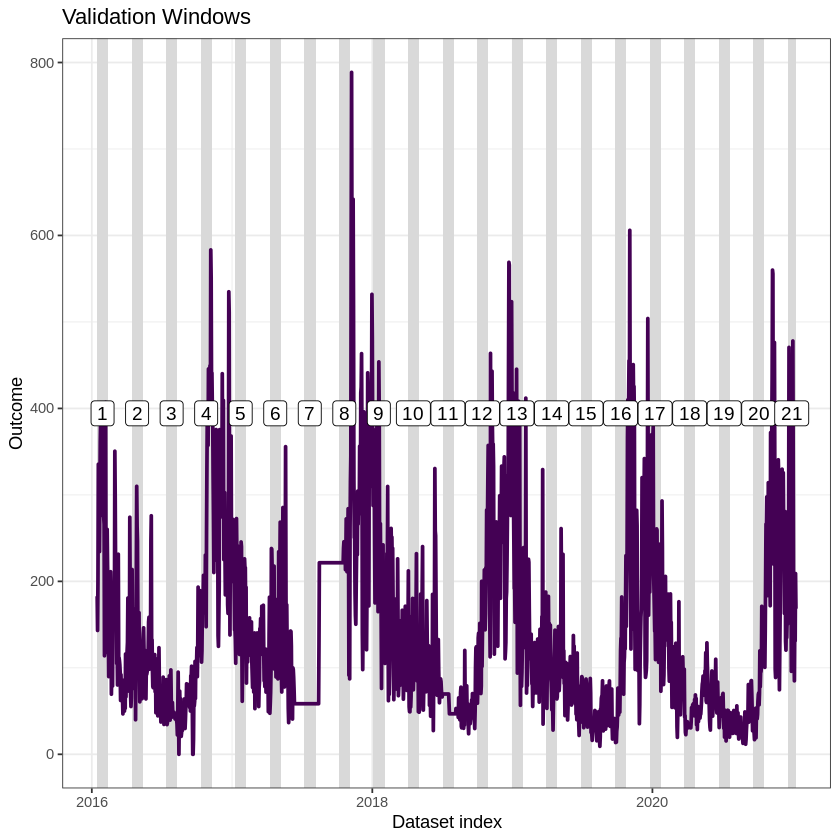

In [11]:
windows <- forecastML::create_windows(lagged_df = data_train_lagged, window_length = 30, skip = 60,
                                      window_start = NULL, window_stop = NULL,
                                      include_partial_window = TRUE)
plot(windows, data_train_lagged,show_labels = TRUE)

In [12]:
###################################### Linear Regression Model #################################

## Time is used to calculate the time running the process
start <- Sys.time()
# User-define model - Linear Regression
model_function_LinReg <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## The output column which you would like to predict PM2.5 in this case
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## Model formulae in the format
  model <- lm(model_formula, data = data) ## Linear model in this case
  return(model)
}


In [13]:
##################### LASSO model ###########################

model_function_LASSO <- function(data, my_outcome_col) {
  
  ## Constant features basically all the independent variables
  constant_features <-
    which(unlist(lapply(data[, -(my_outcome_col)], function(x) {
      !(length(unique(x)) > 1)
    })))
  ## If the contant_feature is greater than 1  
  if (length(constant_features) > 1) {
    data <-
      data[, -c(constant_features + 1)]  # +1 because we're skipping over the outcome column.
  }
  
    ## All the columns except the dependent variables
  x <- data[, -(my_outcome_col), drop = FALSE]
    ## My dependent variables/outcome column
  y <- data[, my_outcome_col, drop = FALSE]
    ## Converting x into matrix
  x <- as.matrix(x, ncol = ncol(x))
    ## Converting y into matrix
  y <- as.matrix(y, ncol = ncol(y))
    ## Now training the lasso model
  model <- cv.glmnet(x, y)
  return(list("model" = model, "constant_features" = constant_features))
}


In [14]:

######################## Random Forest Model ###################################
# Alternatively, we could define an outcome column identifier argument, say, 'outcome_col = 1' in 
# this function or just 'outcome_col' and then set the argument as 'outcome_col = 1' in train_model().

model_function_RF <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## Output column that will be defined
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## model formulae (like PM25 ~ .)
  set.seed(224) ## Setting the seed
  model <-
    randomForest(
      formula = model_formula, ## model_formulae
      data = data, ## the data
      ntree = 200, # try 100, 200, 300, 400, 500 and store the results
      mtry = 4, # try 2, 3, 4, 5
      na.action = na.omit ## Removing missing values if any
    )
}


In [15]:
model_results_LinReg <- forecastML::train_model(
  data_train_lagged, ## Training data
  windows = windows, ## The windows
  model_name = "LinReg", ## Linear Regressing
  model_function = model_function_LinReg, ## The model function
  my_outcome_col = 1, ## PM2.5 as an output column
  use_future = FALSE 
)
end <- Sys.time()
end-start

Time difference of 1.354549 secs

In [16]:
model_results_LASSO <- train_model(
  data_train_lagged, ## data_train 
  windows = windows, ## windows
  model_name = "LASSO", ## Model name as lasso
  model_function = model_function_LASSO, ## Model function is LASSO which we defined up
  my_outcome_col = 1, ## Output column in the first column in the dataframe which will also go in the model_function_LASSO
  use_future = FALSE  
)


In [17]:
model_results_RF <- forecastML::train_model(
    data_train_lagged,
    windows=windows, 
    model_name = "RF", 
    model_function = model_function_RF, 
    use_future = FALSE)
end <- Sys.time()
end-start

Time difference of 2.42229 mins

In [18]:
## Defining the prediction function (Linear model)
prediction_function <- function(model, data_features) {
  data_pred <- data.frame("y_pred" = predict(model, data_features))
  return(data_pred)
}



In [19]:
## Prediction function for LASSO
prediction_function_LASSO <- function(model, data_features) {
  if (length(model$constant_features) > 1) {
    # 'model' was passed as a list.
    data_features <- data_features[, -c(model$constant_features)]
  }
  
  # data_features <- data_features[complete.cases(data_features), ]
  x <- as.matrix(data_features, ncol = ncol(data_features))
  data_pred <-
    data.frame("y_pred" = predict(model$model, x))
  return(data_pred)
}



In [20]:
## In forecast ML, one has to send model and function in a specific format 
data_results <- predict(model_results_LinReg, model_results_LASSO,model_results_RF, ## Models
                        prediction_function = list(prediction_function, prediction_function_LASSO,prediction_function),## Prediction Function 
                        data = data_train_lagged ) ## data

,model,window_start,window_stop,mae,rmse
,<chr>,<date>,<date>,<dbl>,<dbl>
1,LASSO,2016-01-15,2016-01-15,41.86961,50.33246
2,LinReg,2016-01-15,2016-01-15,41.12567,49.26375
3,RF,2016-01-15,2016-01-15,37.92585,51.10014


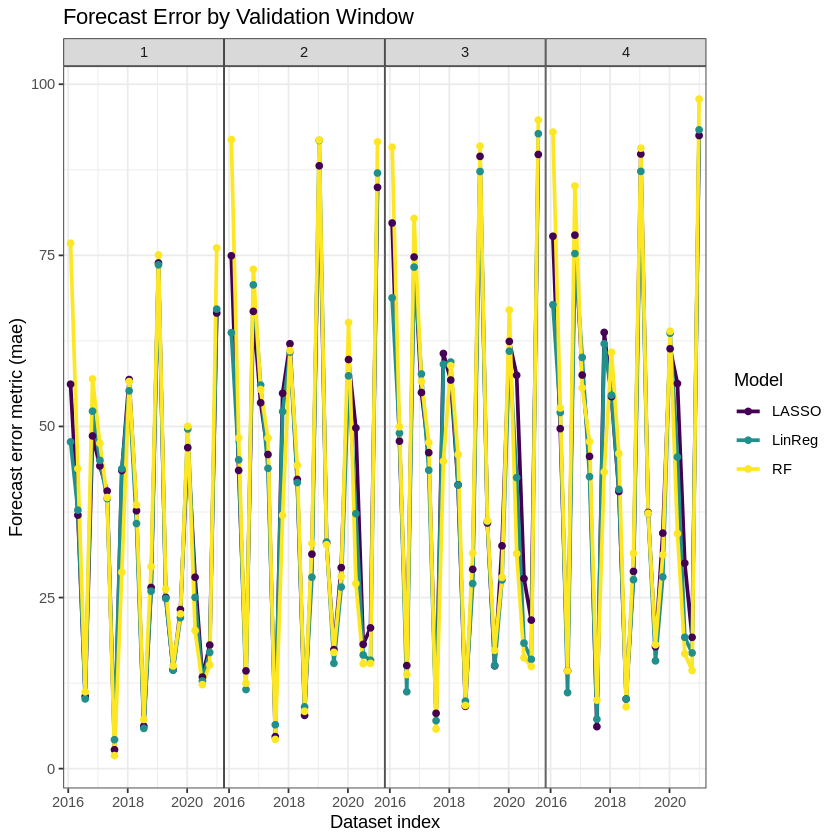

In [21]:
## We will calculate the error 
data_error <- forecastML::return_error(data_results,metrics=c("mae","rmse"),aggregate = "median")
## Will see the error 
head(data_error$error_global)
plot(data_error, facet = ~ horizon, type = "window")

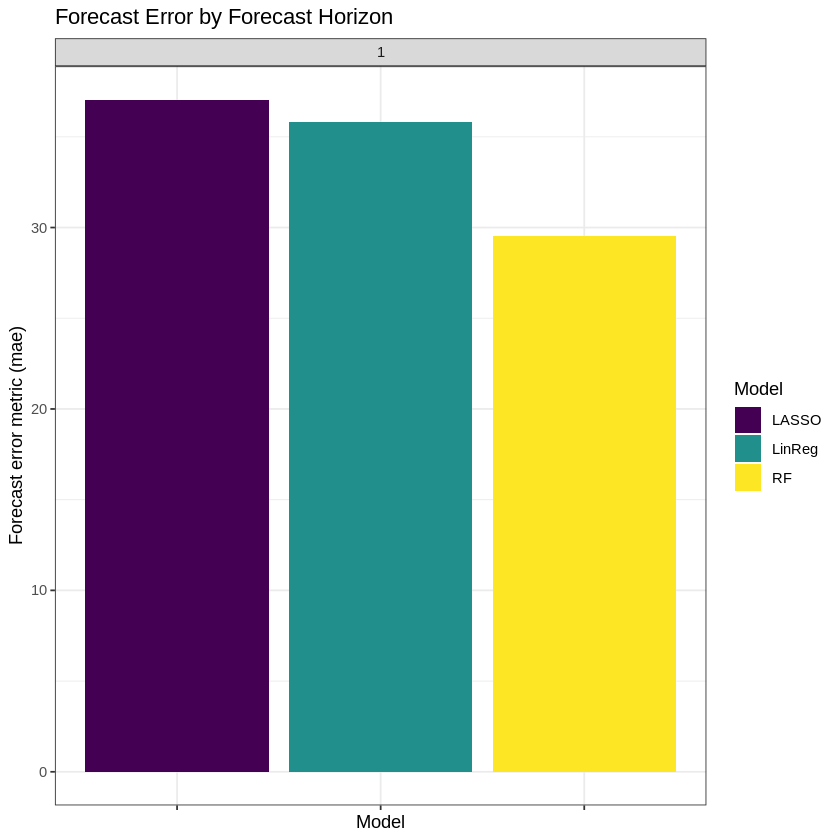

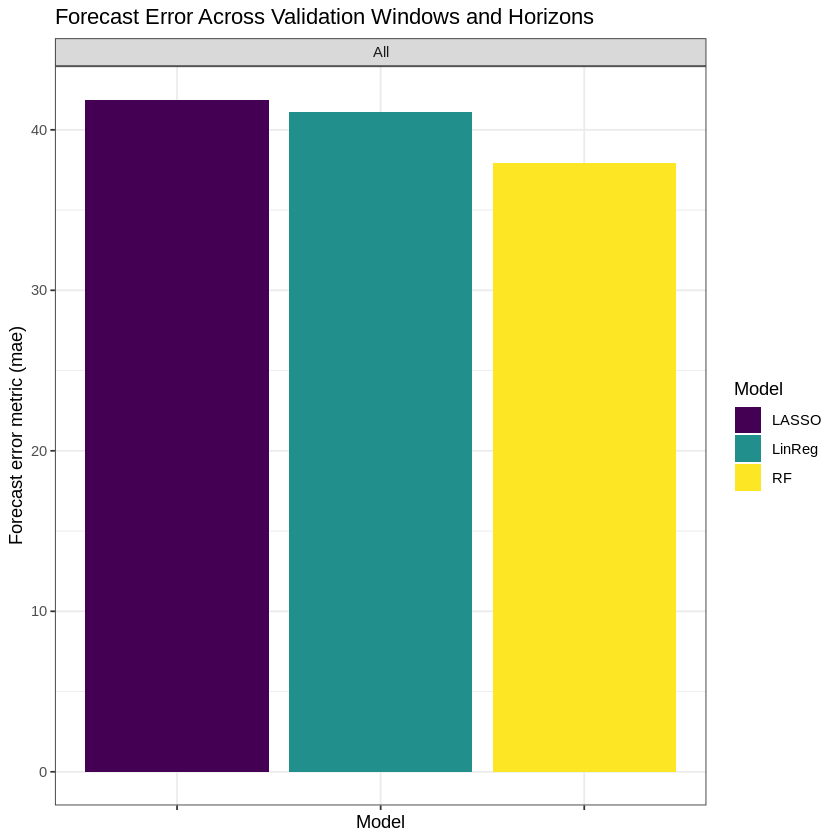

In [22]:
## Showing the error based on horizon
plot(data_error, type = "horizon", facet = ~ horizon, horizons = c(1, 6, 12,24))
## Showing the error across the windos anf facetted by horizon
plot(data_error, type = "global", facet = ~ horizon)

In [23]:
##  Now here we calculate the error metrics which we were not there (using the median across )
#data_results %>% group_by(model,model_forecast_horizon,window_number)%>% ## Group by model, horizon and window 
#summarize(R2=R2(PM25,PM25_pred),MAE=mae(PM25,PM25_pred),  ## Calculating error metrices 
#          NMB=bias(PM25,PM25_pred)/mean(PM25),RMSE=rmse(PM25,PM25_pred),## Normalized RMSE and Bias we divide by mean
#          RRMSE=rmse(PM25,PM25_pred)/mean(PM25))%>%
#group_by(model,model_forecast_horizon)%>%  ## 
#summarize(R2=median(R2),MAE=median(MAE),RMSE=median(RMSE),RRMSE=median(RRMSE),NMB=median(NMB))

data_results %>% group_by(model,model_forecast_horizon) %>%summarize(R2=R2(PM25,PM25_pred),MAE=mae(PM25,PM25_pred),  ## Calculating error metrices 
          NMB=bias(PM25,PM25_pred)/mean(PM25),RMSE=rmse(PM25,PM25_pred),## Normalized RMSE and Bias we divide by mean
          RRMSE=rmse(PM25,PM25_pred)/mean(PM25))

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.



model,model_forecast_horizon,R2,MAE,NMB,RMSE,RRMSE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LASSO,1,0.7924291,33.88076,-9.888945e-03,49.06000,0.3385846
LASSO,2,0.6981350,42.46172,-1.300536e-02,59.60144,0.4113358
LASSO,3,0.6772996,44.94629,-1.948637e-02,61.73964,0.4260924
LASSO,4,0.6730310,45.37200,-2.102470e-02,62.19656,0.4292459
LinReg,1,0.7952436,33.37018,-1.152957e-02,48.35044,0.3336877
LinReg,2,0.7013476,40.85047,-1.617950e-02,58.40559,0.4030827
LinReg,3,0.6852225,42.41309,-1.811353e-02,59.97466,0.4139115
LinReg,4,0.6779854,43.09119,-1.959061e-02,60.66457,0.4186729
RF,1,0.7613357,35.24353,-2.424959e-03,52.33224,0.3611678


In [24]:
data_forecast_list <- forecastML::create_lagged_df(data_train,
                                                   outcome_col = 1,
                                                   type = "forecast",
                                                   horizons = horizons,
                                                   lookback=lookback,
                                                   date = dates[1:nrow(data_train)],
                                                   frequency = "1 day",
                                                   dynamic_features = c( "dailyindex", "monthlyindex", "weeklyindex"), ## dynamicfeatures of index
                                                                                                      )
head(data_forecast_list$horizon_1)

,index,horizon,PM25_lag_1,PM25_lag_2,PM25_lag_3,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_7,PM25_lag_8,PM25_lag_9,PM25_lag_10,PM25_lag_11,PM25_lag_12,PM25_lag_13,PM25_lag_14,dailyindex,monthlyindex,weeklyindex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,2021-01-10,1,168.4271,208.9792,131.1667,148,85,112.4271,148.0729,317.2344,477.9559,298.4167,191.1667,141.8438,95.98958,269.5,NA,NA,NA


In [25]:
dynamic_features <- c( "dailyindex", "monthlyindex", "weeklyindex")
## This merge data is created to merge indexes and we are removing unnecessary columns 
merge_data <- daily_df%>%ungroup(dates)%>%select(-c(dates,year,PM25))
for (i in seq_along(data_forecast_list)) {
    ## Adding date in the data frame horizons
  data_forecast_list[[i]]$dates <-data_forecast_list[[i]]$index
  ##  Now adding the indexes from the merge data frame 
  data_forecast_list[[i]] <- data_forecast_list[[i]] %>%
    mutate(
    day = day(dates),week = week(dates),
    month = month(dates),
    year = year(dates)) %>%select(-dynamic_features)%>% ## First we need to remove these existing features
    left_join(merge_data,by=c("day","week","month"))%>% ## Now we adding these features back using merge data frame 
    select(-c("day","week","month","year","dates"))%>%distinct()
    
}
rm(merge_data)
tail(data_forecast_list$horizon_1)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(dynamic_features)` instead of `dynamic_features` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



,index,horizon,PM25_lag_1,PM25_lag_2,PM25_lag_3,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_7,PM25_lag_8,PM25_lag_9,PM25_lag_10,PM25_lag_11,PM25_lag_12,PM25_lag_13,PM25_lag_14,dailyindex,monthlyindex,weeklyindex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-01-10,1,168.4271,208.9792,131.1667,148,85,112.4271,148.0729,317.2344,477.9559,298.4167,191.1667,141.8438,95.98958,269.5,142.803,170.3057,172.181


In [26]:
## Now we see the forecast on forecast data list
data_forecast <- predict(model_results_LinReg,model_results_LASSO, model_results_RF,  # ... supports any number of ML models.
                         prediction_function = list(prediction_function,prediction_function_LASSO, prediction_function), 
                         data = data_forecast_list)


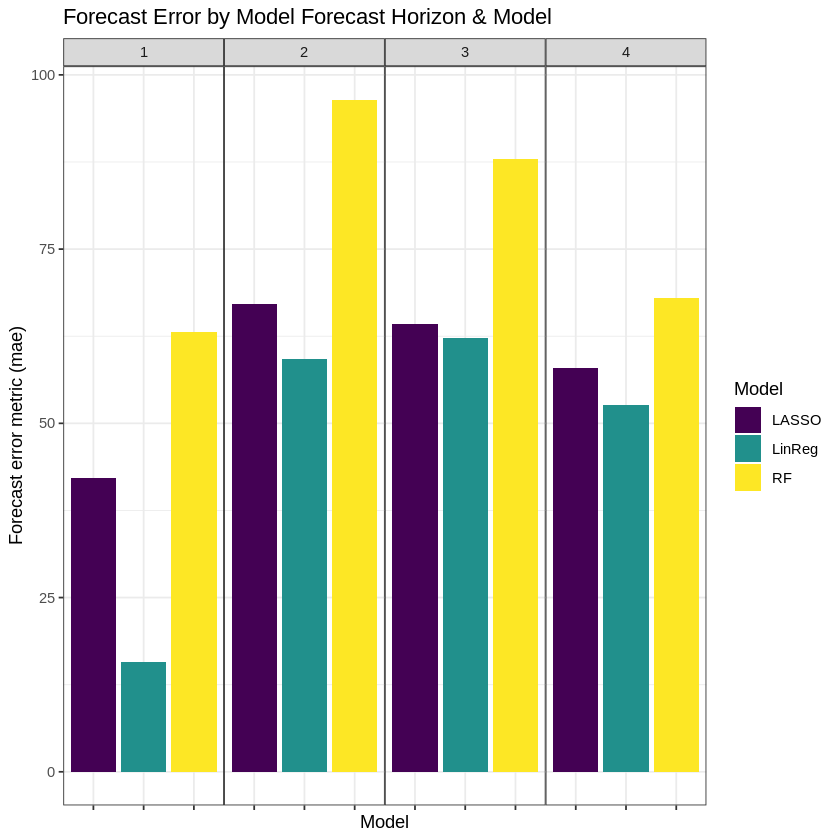

In [27]:
## Testing the model results on the forecast
data_error_forecast <- forecastML::return_error(data_forecast,
                                       data_test = data_test,
                                       test_indices = dates[(nrow(data_train) + 1):length(dates)])
## Plotting the error 
plot(data_error_forecast, facet = ~ horizon, type = "horizon")

In [28]:
daily_df %>% filter(dates > ymd("2021-01-01"))

dates,day,month,year,PM25,week,dailyindex,monthlyindex,weeklyindex
<date>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2021-01-02,2,1,2021,317.2344,1,249.6356,170.3057,222.7684
2021-01-03,3,1,2021,148.0729,1,244.9138,170.3057,222.7684
2021-01-04,4,1,2021,112.4271,1,233.0595,170.3057,222.7684
2021-01-05,5,1,2021,85.0000,1,205.3279,170.3057,222.7684
2021-01-06,6,1,2021,148.0000,1,180.1317,170.3057,222.7684
2021-01-07,7,1,2021,131.1667,2,172.8436,170.3057,172.1810
2021-01-08,8,1,2021,208.9792,2,164.7922,170.3057,172.1810
2021-01-09,9,1,2021,168.4271,2,136.3473,170.3057,172.1810
2021-01-10,10,1,2021,135.5521,2,142.8030,170.3057,172.1810
